In [93]:
from __future__ import print_function

In [94]:
# We'll need numpy for some mathematical operations, and Pandas for some data shaping.
import numpy as np
import pandas as pd

# matplotlib for displaying the output
import matplotlib.pyplot as plt
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

/Users/Jasper/.local/share/virtualenvs/songShape-eCxQOFzy/lib/python3.7/site-packages/librosa/core/audio.py:146: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


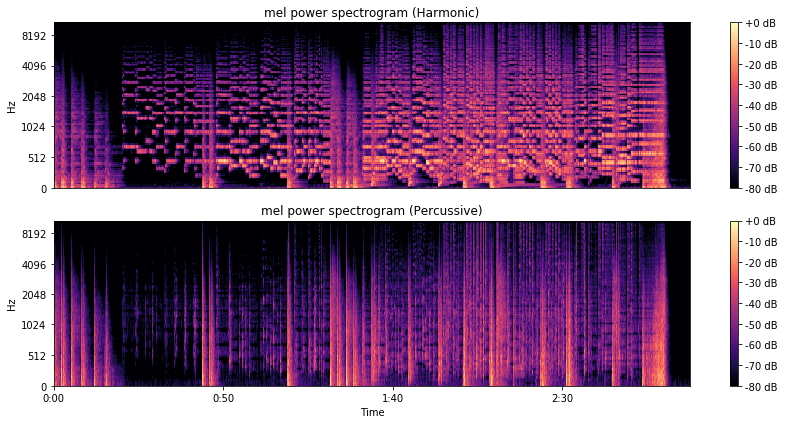

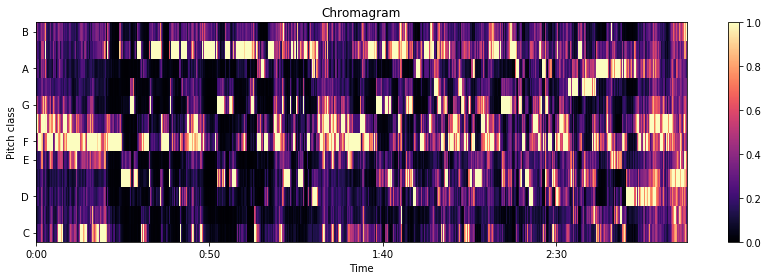

In [105]:
# enter audio path in here
audio_path = "./songs/mp3_m4a/AaronCopland_FanfareForTheCommonMan.m4a"

y, sr = librosa.load(audio_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)

# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()

# We'll use a CQT-based chromagram with 36 bins-per-octave in the CQT analysis.  An STFT-based implementation also exists in chroma_stft()
# We'll use the harmonic component to avoid pollution from transients
C = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=36)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()

In [106]:
# Now, to convert the array to a Pandas DF:
c_df = pd.DataFrame(C)
print(c_df)

        0         1         2         3         4         5         6     \
0   0.162616  0.149306  0.118101  0.098422  0.087702  0.078702  0.072895   
1   0.423887  0.365947  0.267036  0.206813  0.167484  0.140506  0.120720   
2   0.450945  0.384420  0.283141  0.221086  0.182974  0.158222  0.141489   
3   0.381160  0.328497  0.245548  0.200013  0.175012  0.161420  0.153765   
4   0.293566  0.260406  0.201274  0.168676  0.152284  0.145289  0.144291   
5   1.000000  0.847782  0.614437  0.469657  0.389765  0.349107  0.325302   
6   0.937779  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
7   0.833211  0.891075  0.848539  0.821281  0.808686  0.791421  0.777948   
8   0.535271  0.468146  0.363210  0.305354  0.264384  0.232949  0.211934   
9   0.125103  0.119132  0.090302  0.075444  0.063931  0.051832  0.046978   
10  0.088476  0.094674  0.091220  0.097186  0.093441  0.091657  0.093238   
11  0.071437  0.072222  0.072059  0.074166  0.075046  0.076670  0.076532   

        7  

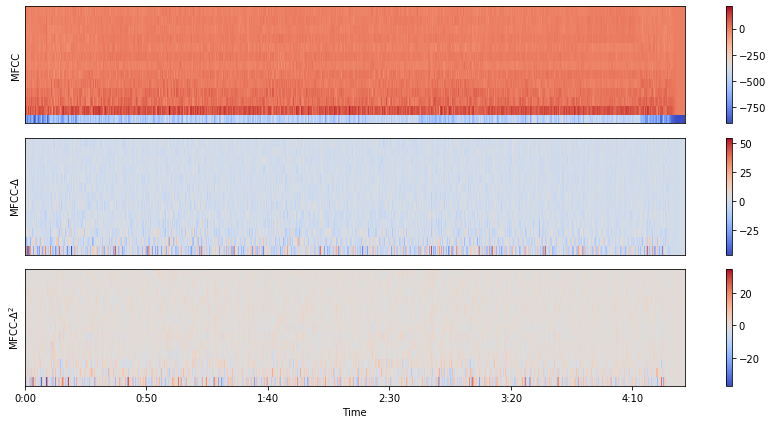

In [85]:
# Next, we'll extract the top 13 Mel-frequency cepstral coefficients (MFCCs)
mfcc        = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# How do they look?  We'll show each in its own subplot
plt.figure(figsize=(12, 6))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.ylabel('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.ylabel('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

# For future use, we'll stack these together into one matrix
M = np.vstack([mfcc, delta_mfcc, delta2_mfcc])

<Figure size 864x432 with 0 Axes>

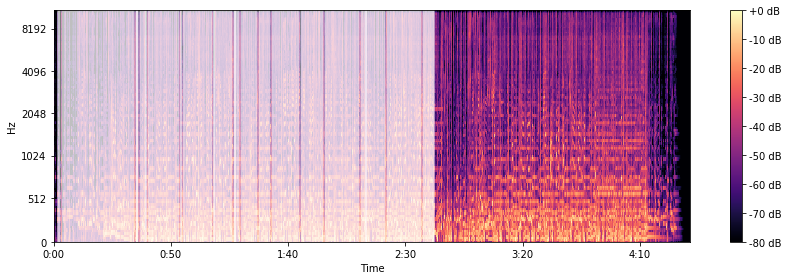

In [89]:
print('Estimated tempo:        %.2f BPM' % tempo)

print('First 5 beat frames:   ', beats[:5])

# Frame numbers are great and all, but when do those beats occur?
print('First 5 beat times:    ', librosa.frames_to_time(beats[:5], sr=sr))

# We could also get frame numbers from times by librosa.time_to_frames()

Estimated tempo:        136.00 BPM
First 5 beat frames:    [ 83 105 127 148 169]
First 5 beat times:     [1.92725624 2.43809524 2.94893424 3.43655329 3.92417234]


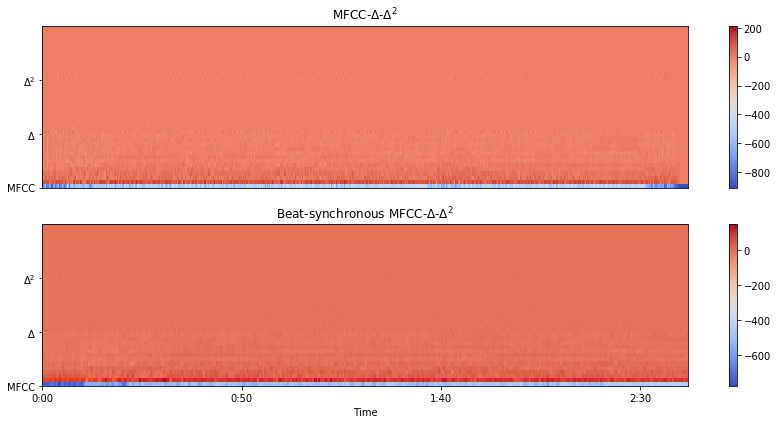

In [90]:
# feature.sync will summarize each beat event by the mean feature vector within that beat

M_sync = librosa.util.sync(M, beats)

plt.figure(figsize=(12,6))

# Let's plot the original and beat-synchronous features against each other
plt.subplot(2,1,1)
librosa.display.specshow(M)
plt.title('MFCC-$\Delta$-$\Delta^2$')

# We can also use pyplot *ticks directly
# Let's mark off the raw MFCC and the delta features
plt.yticks(np.arange(0, M.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])

plt.colorbar()

plt.subplot(2,1,2)
# librosa can generate axis ticks from arbitrary timestamps and beat events also
librosa.display.specshow(M_sync, x_axis='time',
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))

plt.yticks(np.arange(0, M_sync.shape[0], 13), ['MFCC', '$\Delta$', '$\Delta^2$'])             
plt.title('Beat-synchronous MFCC-$\Delta$-$\Delta^2$')
plt.colorbar()

plt.tight_layout()

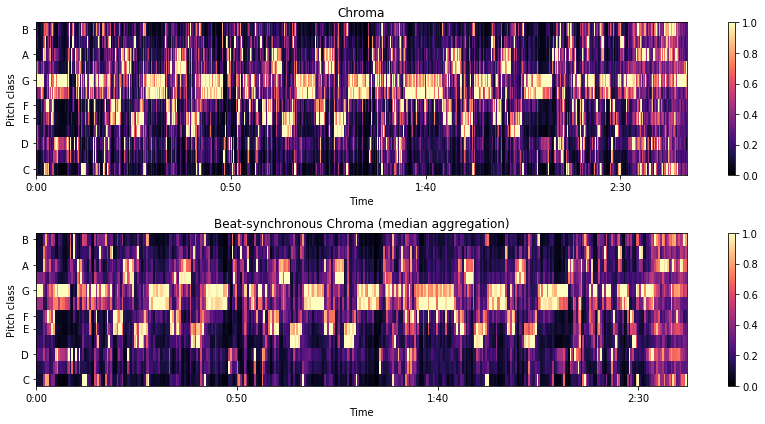

In [91]:
# Beat synchronization is flexible.
# Instead of computing the mean delta-MFCC within each beat, let's do beat-synchronous chroma
# We can replace the mean with any statistical aggregation function, such as min, max, or median.

C_sync = librosa.util.sync(C, beats, aggregate=np.median)

plt.figure(figsize=(12,6))

plt.subplot(2, 1, 1)
librosa.display.specshow(C, sr=sr, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time')

plt.title('Chroma')
plt.colorbar()

plt.subplot(2, 1, 2)
librosa.display.specshow(C_sync, y_axis='chroma', vmin=0.0, vmax=1.0, x_axis='time', 
                         x_coords=librosa.frames_to_time(librosa.util.fix_frames(beats)))


plt.title('Beat-synchronous Chroma (median aggregation)')

plt.colorbar()
plt.tight_layout()